# Rank Based Analysis: (535, 536)
Outlier detection method proposed by Barbara. It is based on these steps: 

1. Order the set by rank on occurrences
2. Extract the subset of values that happens `SENSITIVITY` of the time
3. any value outside [ min(subset), max(subset) ] is an outlier 

Sensitivity is set to:

In [177]:
SENSITIVITY = 0.80

In [178]:
from src import *
from src.models.AlmaClasses import *

from pandas import Series
from pandas import DataFrame
from matplotlib import pyplot
import numpy as np

palette = PaletteFileDB(
    filename='../data/processed/colors-almaAntenna.pkl', 
    colorFunction=paintedForAlmaAntennas )

db = DelaysFileDB( 
    caseName="CaseAntennaObserving", 
    path= '../' + config.FILEPATH_DB + "/delays")  

## Pair to study
As a first example we will study this pair:

In [179]:
(a,b) = (535, 536)
# (a, b) = (543, 544)

In [180]:
 "C_%s: %s" % (a, palette.getColors()[a])

'C_535: [CONTROL/${ANT}/FrontEnd/IFSwitch - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT}/IFProc_A)'

In [181]:
"C_%s: %s" % (b, palette.getColors()[b])

'C_536: [CONTROL/${ANT}/FrontEnd/IFSwitch - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT}/IFProc_B)'

`pandas.Series` is used below, it allows handy serie manipulation.

In [182]:
delays = Series(db.getDelays(a,b))

In [183]:
delays.describe()

count    4778.000000
mean        7.178317
std         6.034547
min         1.000000
25%         3.000000
50%         6.000000
75%        10.000000
max       214.000000
dtype: float64

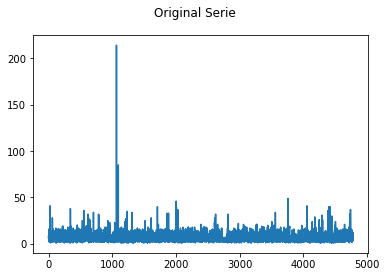

In [184]:
fig = pyplot.figure()
fig.suptitle('Original Serie')
pyplot.plot(delays)
pyplot.show()

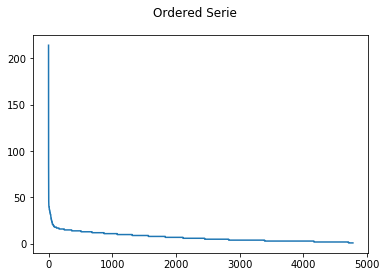

In [185]:
fig = pyplot.figure()
fig.suptitle('Ordered Serie')
# pyplot.yscale('log')
pyplot.plot(sorted(delays, reverse=True))
pyplot.show()

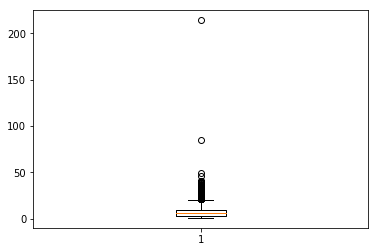

In [203]:
# Simple boxplot
pyplot.boxplot( delays )
pyplot.show()

In [187]:
DataFrame(delays).boxplot()

## Applying Method
Extracting the rank based on # of occurrences, and make a plot

In [204]:
value_counts = delays.value_counts()

print "Value=%s happens %s times" % (value_counts.index[0], value_counts.values[0])
print "Value=%s happens %s times" % (value_counts.index[1], value_counts.values[1])
print "Value=%s happens %s times" % (value_counts.index[10], value_counts.values[10])


value_counts

Value=3 happens 774 times
Value=4 happens 564 times
Value=12 happens 188 times


3      774
4      564
2      543
5      377
6      340
7      278
8      265
9      254
10     235
11     207
12     188
13     172
14     148
15     116
16      83
1       70
17      40
18      33
19      11
21      11
20       8
32       5
36       5
24       5
40       4
23       4
26       4
28       3
33       3
31       3
25       3
34       3
27       3
39       2
37       2
41       2
22       2
29       1
49       1
35       1
30       1
38       1
46       1
214      1
85       1
dtype: int64

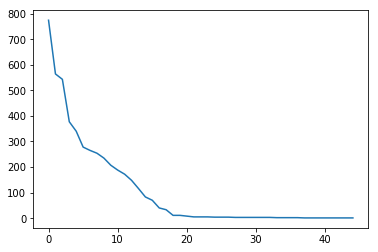

In [205]:
pyplot.plot(value_counts.values)
pyplot.show()

The rank obtained in `value_counts` shows that the evident `outlier=214` happens only 1 time, 41 happens 2 times. Let's see the tail of the ordered original delays: (yes, they are here!)

In [190]:
sorted(delays)[-10:]

[40, 40, 40, 40, 41, 41, 46, 49, 85, 214]

Now, obtain the subset of values that, combined, appears `SENSITIVE` amount of times

In [191]:
# Cumulative sum on value_counts.
cumsum = value_counts.cumsum()
cumsum

3       774
4      1338
2      1881
5      2258
6      2598
7      2876
8      3141
9      3395
10     3630
11     3837
12     4025
13     4197
14     4345
15     4461
16     4544
1      4614
17     4654
18     4687
19     4698
21     4709
20     4717
32     4722
36     4727
24     4732
40     4736
23     4740
26     4744
28     4747
33     4750
31     4753
25     4756
34     4759
27     4762
39     4764
37     4766
41     4768
22     4770
29     4771
49     4772
35     4773
30     4774
38     4775
46     4776
214    4777
85     4778
dtype: int64

In [192]:
total = cumsum[-1:].values[0]
total

4778

In [193]:
percentageCumsum = cumsum / total
percentageCumsum 

3      0.161992
4      0.280033
2      0.393679
5      0.472583
6      0.543742
7      0.601925
8      0.657388
9      0.710548
10     0.759732
11     0.803056
12     0.842403
13     0.878401
14     0.909376
15     0.933654
16     0.951026
1      0.965676
17     0.974048
18     0.980954
19     0.983257
21     0.985559
20     0.987233
32     0.988280
36     0.989326
24     0.990373
40     0.991210
23     0.992047
26     0.992884
28     0.993512
33     0.994140
31     0.994768
25     0.995396
34     0.996023
27     0.996651
39     0.997070
37     0.997488
41     0.997907
22     0.998326
29     0.998535
49     0.998744
35     0.998954
30     0.999163
38     0.999372
46     0.999581
214    0.999791
85     1.000000
dtype: float64

In [194]:
# Note that this method is simpler, but the very explicit results with percentageCumsum is shown for clarity
#typicalValues = cumsum[ cumsum <= SENSITIVITY * total ]

typicalValues = percentageCumsum[ percentageCumsum <= SENSITIVITY]
typicalValues

3     0.161992
4     0.280033
2     0.393679
5     0.472583
6     0.543742
7     0.601925
8     0.657388
9     0.710548
10    0.759732
dtype: float64

In [195]:
minVal, maxVal = min(typicalValues.index), max(typicalValues.index)
minVal, maxVal

(2, 10)

# Testing the method
A graph with the "typical" part (minVal < t < maxVal) is shown, with some stats metrics.

In [196]:
typicalDelays = delays[ minVal <= delays ][ delays <= maxVal ]
typicalDelays.describe()

count    3630.000000
mean        5.038843
std         2.479873
min         2.000000
25%         3.000000
50%         4.000000
75%         7.000000
max        10.000000
dtype: float64

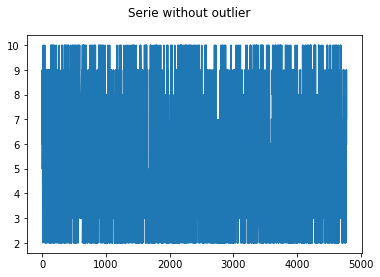

In [197]:
fig = pyplot.figure()
fig.suptitle('Serie without outlier')
pyplot.plot(typicalDelays)
pyplot.show()

Found Outliers:

In [198]:
"%s of %s (%.3f%%)" % ( len(delays) - len(typicalDelays), len(delays), (1.0*len(delays) - len(typicalDelays))/len(delays) )

'1148 of 4778 (0.240%)'

In [199]:
delays[ delays < minVal ].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [200]:
delays[ maxVal < delays ].sort_values().values

array([ 11,  11,  11, ...,  49,  85, 214])

In [201]:
# All the above in one function
def minmax_rank_based( values, sensitivity ):
    value_counts = Series(delays).value_counts()
    cumsum = value_counts.cumsum()
    typicalValues = cumsum[ cumsum <= sensitivity * value_counts.sum() ]
    return min(typicalValues.index), max(typicalValues.index)

In [202]:
minmax_rank_based( db.getDelays(535,536), SENSITIVITY )

(2, 10)

## Discussion
I believe that the only clear outlier is 214. value=85 seems high in this set, it could be labeled as outlier too. But the other values looks pretty inside a normal range.